In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import torch
import tqdm
import umap

import celltrip

os.environ['AWS_PROFILE'] = 'waisman-admin'
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# Load Data and Policy

In [3]:
# Read data files
adata, = celltrip.utility.processing.read_adatas('../data/VirtualCell/expression.h5ad', backed=True)  # 's3://nkalafut-celltrip/VirtualCell/expression.h5ad'
# Model location and name (should be prefix for .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251001', 800  # No mask
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251006', 800  # Normal
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251007', 800  # 16 dim - Not much diff. betw. runs
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251007-celllog', 800  # 16 dim - sample and log norm
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251007-celllog-32', 800  # 32 dim
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251008-celllog-64', 800  # 64 dim, 1024 PCA
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
    mask = np.loadtxt(f).astype(bool)
# assert (adata.obs['training'] == mask).all()
# Create sample env (kind of a dumb workaround, TODO)
m1, = preprocessing.transform([adata[:2].X])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), compute_rewards=False, dim=32).eval().to('cuda')
# Load policy
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=100, vision_size=1_000).eval().to('cuda')  # TODO Forward batch size reduced
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [4]:
preprocessing_nopca = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
preprocessing_nopca.pca_dim = None


# Generate Steady State

In [5]:
# # Get random sample
# np.random.seed(42)
# sample_idx = np.sort(np.random.choice(adata.obs.shape[0], 10_000, replace=False))
# m1_raw = celltrip.utility.processing.chunk(adata.X[sample_idx], chunk_size=2_000)
# m1, = preprocessing.transform([m1_raw])


In [6]:
# # Create environment
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), compute_rewards=False, dim=8).eval(time_scale=1).to('cuda')

# # Simulate
# ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=True)
# steady_state = ret[-1][-1, :, :env.dim]
# # target_state = env.modalities[env.target_modalities[0]].cpu()

# # Impute
# with torch.no_grad():
#     imputed_steady_state = policy.pinning[0](steady_state.to('cuda')).detach().cpu().numpy()
# imputed_steady_state, = preprocessing.inverse_transform([imputed_steady_state])

# # Compute accuracy
# mse = np.square(m1_raw - imputed_steady_state).mean()
# print(f'MSE: {mse:.3f}')


In [7]:
# # Latent space plot
# red = umap.UMAP(random_state=42)
# df = pd.DataFrame(index=sample_idx)
# df[['X_lat', 'Y_lat']] = red.fit_transform(steady_state)
# df['Target'] = adata[sample_idx].obs['target_gene'].to_numpy()
# df['Select Targets'] = df['Target']
# df.loc[~df['Target'].isin(['TMSB4X', 'EWSR1', 'non-targeting']), 'Select Targets'] = 'Other'
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# sns.scatterplot(df, x='X_lat', y='Y_lat', hue='Select Targets', s=5, legend=True, ax=ax)


# Predict Perturbation Outcomes

In [ ]:
# Get non-targeting
non_targeting_sample_idx = np.argwhere(adata.obs['target_gene']=='non-targeting').flatten()
np.random.seed(42)
non_targeting_sample_idx = np.sort(np.random.choice(non_targeting_sample_idx, 5_000, replace=False))  # Subsample for performance
non_targeting_raw = celltrip.utility.processing.chunk(adata.X[non_targeting_sample_idx], chunk_size=2_000)
non_targeting_trans, = preprocessing.transform([non_targeting_raw])

# Create environment
env = (
    celltrip.environment.EnvironmentBase(
        torch.tensor(non_targeting_trans), compute_rewards=False, dim=env.dim)
        .eval(time_scale=1)
        .set_incorporation_params(retention=1., binding=1.)  # Nothing at all
        .to('cuda'))

# Simulate (Runs at around .61x realtime on 38k cells!)
ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=True)
non_targeting_steady_state = ret[-1][-1]
print(f'Mean Velocity: {env.vel.abs().mean(dim=-1).mean():.3f}')

# Simulate with incorporation
# env.reset().set_state(non_targeting_steady_state.to('cuda'))
# ret = celltrip.train.simulate_until_completion(env, policy, incorporate_predictions=False, skip_states=100, store_states='cpu', progress_bar=True)
# env.solidify_offsets()
# non_targeting_steady_state = ret[-1][-1]
# print(env.vel.abs().mean(dim=-1).mean())

# Impute
with torch.no_grad():
    imputed_non_targeting_steady_state = policy.pinning[0](non_targeting_steady_state[..., :env.dim].to('cuda')).detach().cpu().numpy()
imputed_non_targeting_steady_state, = preprocessing.inverse_transform([imputed_non_targeting_steady_state])


1281it [00:06, 191.14it/s]


Mean Velocity: 0.006


In [ ]:
imputed_means, raw_means = [], []
num_genes = 80
gene_list = ['_ctl_pre', '_ctl_post'] + adata.obs.loc[adata.obs['target_gene']!='non-targeting'].groupby('target_gene', observed=True).size().sort_values(ascending=False).index.to_numpy()[:num_genes].tolist()
# imputed_non_targeting_steady_state_mean = imputed_non_targeting_steady_state.mean(axis=0)
# non_targeting_raw_mean = non_targeting_raw.mean(axis=0)
for gene in (pbar := tqdm.tqdm(gene_list)):
    # Update pbar
    pbar.set_description(gene)

    # Find gene
    if gene == '_ctl_pre':
        # imputed_means.append(preprocessing_nopca.transform([imputed_non_targeting_steady_state])[0].mean(axis=0))
        # raw_means.append(preprocessing_nopca.transform([non_targeting_raw])[0].mean(axis=0))
        imputed_means.append(imputed_non_targeting_steady_state.mean(axis=0))
        raw_means.append(non_targeting_raw.mean(axis=0))
        continue
    elif gene == '_ctl_post':
        gene_idx = []
    else:
        gene_idx = np.argwhere(adata.var.index == gene).flatten()
        assert len(gene_idx) == 1

    # # Get perturbation (~65s)
    # # iso_modality = preprocessing.transform(non_targeting_raw, subset_modality=0, subset_features=gene_idx)
    # iso_modality = celltrip.utility.processing.chunk(
    #     non_targeting_raw, chunk_size=2_000, func=lambda x: preprocessing.transform(x, subset_modality=0, subset_features=gene_idx)[0])
    # iso_modality = torch.tensor(iso_modality).to('cuda')

    # Reset environment and simulate
    env.reset().set_state(non_targeting_steady_state.to('cuda'))
    # env.modalities[0] = torch.tensor(non_targeting_trans).to('cuda')
    # env.modalities[0] = env.modalities[0] - iso_modality  # Knockdown - NOTE: If `pre_log` and nonzero knockdown, then need to do zero knockdown + other
    ret = celltrip.train.simulate_until_completion(
        env, policy,
        incorporate_predictions=False,
        env_hooks=[
            # celltrip.utility.hooks.clamp_input_features_hook(
            #     gene_idx, preprocessing, feature_targets=0., modality_idx=0, device=env.device),
            celltrip.utility.hooks.clamp_inverted_features_hook(
                gene_idx, preprocessing, feature_targets=0., modality_idx=0),
        ],
        action_hooks=[
            celltrip.utility.hooks.move_toward_targets_hook(
                gene_idx, feature_targets=0., pinning=policy.pinning[0],
                preprocessing=preprocessing, modality_idx=0,
                factor=1, device=env.device),
        ],  # Factor 1e4
        skip_states=100, store_states='cpu', progress_bar=False)
    gene_steady_state = ret[-1][-1]
    print(f'Mean Velocity: {env.vel.abs().mean(dim=-1).mean():.3f}')

    # Impute
    with torch.no_grad():
        imputed_gene_steady_state = policy.pinning[0](gene_steady_state[..., :env.dim].to('cuda')).detach().cpu().numpy()
    imputed_gene_steady_state, = preprocessing.inverse_transform([imputed_gene_steady_state])

    # Get true perturbed data
    if gene == '_ctl_post':
        gene_raw = non_targeting_raw
    else:
        gene_sample_idx = np.argwhere(adata.obs['target_gene']==gene).flatten()
        # gene_raw = celltrip.utility.processing.chunk(adata.X[gene_sample_idx], chunk_size=2_000)
        # gene_trans, = preprocessing.transform([gene_raw])
    
    # Record
    # imputed_means.append(preprocessing_nopca.transform([imputed_gene_steady_state])[0].mean(axis=0))
    # raw_means.append(preprocessing_nopca.transform([gene_raw])[0].mean(axis=0))
    imputed_means.append(imputed_gene_steady_state.mean(axis=0))
    raw_means.append(gene_raw.mean(axis=0))

# Aggregate
imputed_means = np.stack(imputed_means, axis=0)
imputed_means = pd.DataFrame(imputed_means, index=gene_list, columns=adata.var.index.to_numpy())
raw_means = np.stack(raw_means, axis=0)  # np.concatenate(raw_means, axis=0)
raw_means = pd.DataFrame(raw_means, index=gene_list, columns=adata.var.index.to_numpy())

# Save
imputed_means.to_csv('../plots/vcc/imputed_means.csv')
raw_means.to_csv('../plots/vcc/raw_means.csv')


TMSB4X:   9%|▉         | 2/22 [00:06<01:03,  3.17s/it]   

Mean Velocity: 0.006


PRCP:  14%|█▎        | 3/22 [00:17<02:02,  6.43s/it]  

Mean Velocity: 0.770


TADA1:  18%|█▊        | 4/22 [00:28<02:28,  8.28s/it]

Mean Velocity: 0.918


HIRA:  23%|██▎       | 5/22 [00:39<02:38,  9.32s/it] 

Mean Velocity: 0.818


IGF2R:  27%|██▋       | 6/22 [00:51<02:38,  9.93s/it]

Mean Velocity: 0.929


NCK2:  32%|███▏      | 7/22 [01:02<02:33, 10.24s/it] 

Mean Velocity: 0.932


MED13:  36%|███▋      | 8/22 [01:13<02:27, 10.56s/it]

Mean Velocity: 0.862


MED12:  41%|████      | 9/22 [01:24<02:18, 10.67s/it]

Mean Velocity: 0.857


STAT1:  45%|████▌     | 10/22 [01:36<02:12, 11.03s/it]

Mean Velocity: 0.941


USP22:  50%|█████     | 11/22 [01:48<02:06, 11.49s/it]

Mean Velocity: 0.865


MED13L:  55%|█████▍    | 12/22 [01:59<01:53, 11.37s/it]

Mean Velocity: 0.842


TET1:  59%|█████▉    | 13/22 [02:10<01:40, 11.19s/it]  

Mean Velocity: 0.803


KIF1B:  64%|██████▎   | 14/22 [02:21<01:28, 11.06s/it]

Mean Velocity: 0.771


SRC:  68%|██████▊   | 15/22 [02:32<01:18, 11.15s/it]  

Mean Velocity: 0.879


PBX1:  73%|███████▎  | 16/22 [02:44<01:08, 11.35s/it]

Mean Velocity: 0.863


CAST:  77%|███████▋  | 17/22 [02:55<00:55, 11.15s/it]

Mean Velocity: 0.862


IDE:  82%|████████▏ | 18/22 [03:06<00:44, 11.16s/it] 

Mean Velocity: 0.917


MAPKAPK2:  86%|████████▋ | 19/22 [03:17<00:33, 11.06s/it]

Mean Velocity: 0.820


PTPN1:  91%|█████████ | 20/22 [03:28<00:22, 11.15s/it]   

Mean Velocity: 0.870


KDM2B:  95%|█████████▌| 21/22 [03:40<00:11, 11.34s/it]

Mean Velocity: 0.797


KDM2B: 100%|██████████| 22/22 [03:51<00:00, 10.51s/it]

Mean Velocity: 0.822


# Visualize Perturbation Results

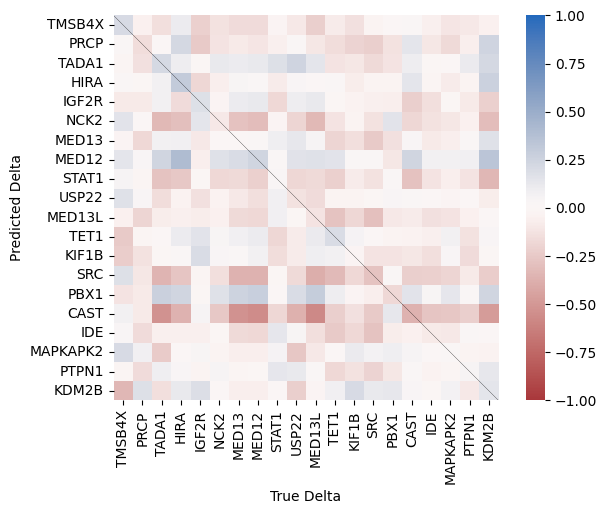

In [13]:
# Load
imputed_means = pd.read_csv('../plots/vcc/imputed_means.csv', index_col=0)
raw_means = pd.read_csv('../plots/vcc/raw_means.csv', index_col=0).iloc[:imputed_means.shape[0]]

# Transform
# imputed_means[:], = preprocessing_nopca.inverse_transform([imputed_means.to_numpy()])
# raw_means[:], = preprocessing_nopca.inverse_transform([raw_means.to_numpy()])

# Lose information from PCA
# raw_means[:], = preprocessing.inverse_transform(preprocessing.transform([raw_means.to_numpy()]))  # Invalid if log
# raw_means[:], = preprocessing_nopca.transform(preprocessing.inverse_transform(preprocessing.transform(preprocessing_nopca.inverse_transform([raw_means.to_numpy()]))))

# Get differences
imputed_mean_diffs = imputed_means.iloc[2:] - imputed_means.loc['_ctl_post']
# imputed_mean_diffs = imputed_means.iloc[2:] - imputed_means.loc['_ctl_pre']
# imputed_mean_diffs = imputed_means.iloc[2:] - raw_means.loc['_ctl_post']
raw_mean_diffs = raw_means.iloc[2:] - raw_means.loc['_ctl_post']

# Get 1k highly variant genes
assert preprocessing.filter_mask[0] is None
# high_var_idx = preprocessing.standardize_std[0][0].argsort()[::-1][:1000]
high_var_idx = np.array(np.argsort(np.std(adata.X[:1000].log1p().todense(), axis=0))).flatten()[::-1][:200]
high_var_genes = adata.var.index[high_var_idx]

# Compute correlations
cross_correlation = np.corrcoef(imputed_mean_diffs, raw_mean_diffs)[:imputed_mean_diffs.shape[0], -raw_mean_diffs.shape[0]:]
# cross_correlation = np.corrcoef(imputed_mean_diffs[high_var_genes], raw_mean_diffs[high_var_genes])[:imputed_mean_diffs.shape[0], -raw_mean_diffs.shape[0]:]
cross_correlation = pd.DataFrame(cross_correlation, index=imputed_mean_diffs.index, columns=raw_mean_diffs.index)

# Dendogram sorting
# dist = scipy.spatial.distance.pdist(cross_correlation.T)
# linkage = scipy.cluster.hierarchy.linkage(dist, method='ward')
# ordered_linkage = scipy.cluster.hierarchy.optimal_leaf_ordering(linkage, dist)
# ordered_leaves = scipy.cluster.hierarchy.leaves_list(ordered_linkage)
# cross_correlation = cross_correlation.iloc[ordered_leaves, ordered_leaves]

# Format correlation matrix
cross_correlation_scaled_col = (cross_correlation - np.min(cross_correlation, axis=0)) / (np.max(cross_correlation, axis=0) - np.min(cross_correlation, axis=0))
cross_correlation_scaled_row = (cross_correlation - np.min(cross_correlation, axis=1)) / (np.max(cross_correlation, axis=1) - np.min(cross_correlation, axis=1))
cross_correlation_rank = cross_correlation.shape[0] - np.argsort(np.argsort(cross_correlation, axis=0), axis=0)
cross_correlation_rank = pd.DataFrame(cross_correlation_rank, index=imputed_mean_diffs.index, columns=raw_mean_diffs.index)

# Diagonal summary
pert_summary = pd.DataFrame({
    'Gene': cross_correlation.index,
    'Rank': np.diag(cross_correlation_rank),
    'Correlation': np.diag(cross_correlation),
    'Observed Expression': raw_means.loc['_ctl_post', raw_mean_diffs.index],
    'Observed Knockdown': np.diag(raw_mean_diffs[raw_mean_diffs.index]),
    'Observed Knocked Expression': raw_means.loc['_ctl_post', raw_mean_diffs.index] + np.diag(raw_mean_diffs[raw_mean_diffs.index]),
    'Observed Knockdown Rank': 1 + np.diag(np.argsort(np.argsort(raw_mean_diffs[raw_mean_diffs.index], axis=0), axis=0)),
    'Imputed Expression': imputed_means.loc['_ctl_post', imputed_mean_diffs.index],
    'Imputed Knockdown': np.diag(imputed_mean_diffs[imputed_mean_diffs.index]),
    'Imputed Knocked Expression': imputed_means.loc['_ctl_post', imputed_mean_diffs.index] + np.diag(imputed_mean_diffs[imputed_mean_diffs.index]),
    'Imputed Knockdown Rank': 1 + np.diag(np.argsort(np.argsort(imputed_mean_diffs[imputed_mean_diffs.index], axis=0), axis=0))})
pert_summary['Ratio'] = pert_summary['Imputed Knockdown'] / pert_summary['Observed Knockdown']

# Plot
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(cross_correlation, cmap='vlag_r', vmin=-1, vmax=1, ax=ax)
# sns.heatmap(cross_correlation_scaled_col, cmap='Blues', vmin=0, vmax=1, ax=ax)
# sns.heatmap(cross_correlation_scaled_row, cmap='Blues', vmin=0, vmax=1, ax=ax)
# sns.heatmap(cross_correlation_rank, cmap='Blues_r', vmin=1, vmax=cross_correlation.shape[0], ax=ax)
ax.plot([0, cross_correlation.shape[0]], [0, cross_correlation.shape[0]], lw=.2, color='black')
ax.set(xlabel='True Delta', ylabel='Predicted Delta')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_aspect('equal')


In [14]:
pert_summary


,Gene,Rank,Correlation,Observed Expression,Observed Knockdown,Observed Knocked Expression,Observed Knockdown Rank,Imputed Expression,Imputed Knockdown,Imputed Knocked Expression,Imputed Knockdown Rank,Ratio
TMSB4X,TMSB4X,1,0.210848,135.356030,-128.957514,6.398516,1,23.627354,-23.581304,0.046050,1,0.182861
PRCP,PRCP,16,-0.151592,6.184002,-5.831656,0.352347,1,0.961928,-0.959177,0.002751,1,0.164478
TADA1,TADA1,3,0.215473,1.153998,-1.100962,0.053036,1,0.190379,-0.190607,-0.000228,1,0.173128
HIRA,HIRA,2,0.303991,9.302001,-1.225353,8.076648,1,1.536897,-1.529909,0.006988,1,1.248546
IGF2R,IGF2R,3,0.173823,3.721999,-3.375907,0.346092,1,0.559888,-0.559313,0.000575,1,0.165678
NCK2,NCK2,15,-0.098264,2.059996,-1.954500,0.105497,1,0.331417,-0.331051,0.000366,1,0.169379
MED13,MED13,8,0.014330,6.088000,-5.761844,0.326157,1,1.040839,-1.040206,0.000633,1,0.180534
MED12,MED12,2,0.238586,4.383997,-4.195639,0.188358,1,0.621471,-0.620419,0.001052,1,0.147872
STAT1,STAT1,8,0.035545,3.175997,-2.997096,0.178901,1,0.568249,-0.567680,0.000569,1,0.189410
USP22,USP22,14,-0.129008,20.932000,-20.000250,0.931750,1,3.596261,-3.585242,0.011019,1,0.179260


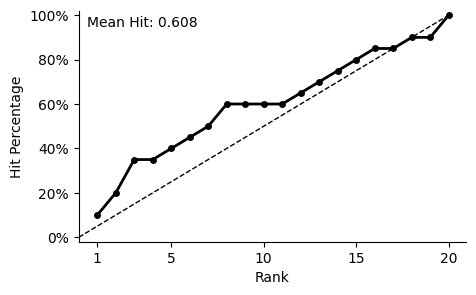

In [15]:
# Get hit df
df = pd.DataFrame({'Rank': 1+np.arange(pert_summary.shape[0])})
df['Hits'] = df['Rank'].apply(lambda r: (pert_summary['Rank'] <= r).sum())
df['Hit Percentage'] = df['Hits'] / pert_summary.shape[0]
auc = df['Hit Percentage'].mean()  # * (df.shape[0]/(df.shape[0]+1))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.lineplot(df, x='Rank', y='Hit Percentage', lw=2, marker='.', markersize=10, markeredgecolor='none', color='black', ax=ax)
sns.despine(ax=ax)
ax.set_xlim(left=0)
ax.set_ylim(-.02, 1.02)
ax.set_xticks([1]+np.arange(5, pert_summary.shape[0]+5, 5).tolist())
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.))
ax.text(.02, .98, f'Mean Hit: {auc:.3f}', ha='left', va='top', fontsize='medium', transform=ax.transAxes)
ax.plot([0, pert_summary.shape[0]], [0, 1], ls='--', lw=1, color='black');


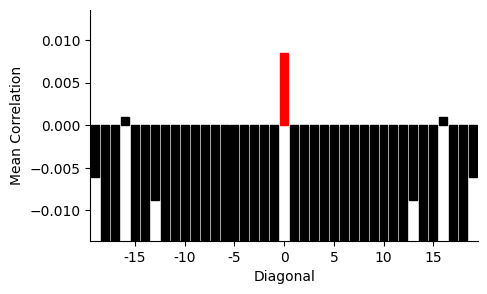

In [16]:
# Get hit df
df = pd.DataFrame({'Diagonal': np.arange(-pert_summary.shape[0]+1, pert_summary.shape[0])})
diag_corr = [np.diag(np.roll(cross_correlation, i, axis=0)).mean() for i in range(cross_correlation.shape[0])]
df['Mean Correlation'] = diag_corr[:0:-1] + diag_corr

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
bar = sns.barplot(df, x='Diagonal', y='Mean Correlation', color='black', edgecolor='black', ax=ax)
# Highlight
ax.patches[len(diag_corr)-1].set(color='red', edgecolor='red')
# Styling
sns.despine(ax=ax)
max_ylim = max(*ax.get_ylim())
ax.set_ylim(-max_ylim, max_ylim)
xticks = np.arange(0, len(diag_corr), 5)
xticks = np.concat([-xticks[:0:-1], xticks])
ax.set(xticks=xticks+df['Diagonal'].max(), xticklabels=xticks);


/tmp/ipykernel_90025/2340559097.py:15: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  bar = sns.barplot(df.loc[df['Type'].str.endswith('Expression')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightblue'], edgecolor='none', width=.8, ax=ax)
/tmp/ipykernel_90025/2340559097.py:16: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  bar = sns.barplot(df.loc[df['Type'].str.endswith('Knocked Expression')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightcoral'], edgecolor='none', width=.4, ax=ax)


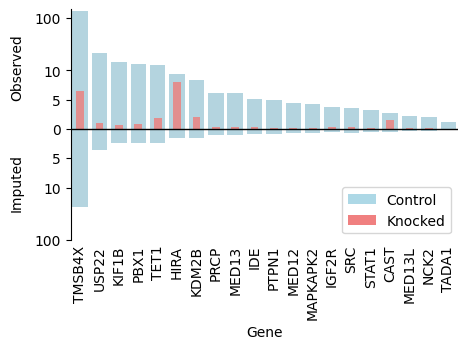

In [9]:
# Pivot
df = pert_summary.melt(
    id_vars='Gene',
    value_vars=[
        'Observed Expression', 'Imputed Expression',
        # 'Observed Knockdown', 'Imputed Knockdown',
        'Observed Knocked Expression', 'Imputed Knocked Expression'],
    var_name='Type', value_name='Value').sort_values('Value', ascending=False)
df.loc[df['Type'].str.startswith('Imputed'), 'Value'] *= -1

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
# bar = sns.barplot(df.loc[df['Type'].str.endswith('Observed')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightblue', 'lightblue'], edgecolor='none', width=.8, ax=ax)
# bar = sns.barplot(df.loc[df['Type'].str.startswith('Imputed')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightcoral', 'lightcoral'], edgecolor='none', width=.4, ax=ax)
bar = sns.barplot(df.loc[df['Type'].str.endswith('Expression')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightblue'], edgecolor='none', width=.8, ax=ax)
bar = sns.barplot(df.loc[df['Type'].str.endswith('Knocked Expression')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightcoral'], edgecolor='none', width=.4, ax=ax)
# bar.get_legend().set_title('')
ax.set_yscale('symlog', linthresh=10)
ax.axhline(y=0, lw=1., color='black')
yticks = [-100, -10, -5, 0, 5, 10, 100]
ax.set(yticks=yticks, yticklabels=np.abs(yticks))
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# Styling
sns.despine(bottom=True, ax=ax)
ax.tick_params(axis='x', which='major', length=0)
ax.set_ylabel(None)
# ax.text(-.12, .75, 'Expression', ha='right', va='center', rotation=90, transform=ax.transAxes)
# ax.text(-.12, .25, 'Knockdown', ha='right', va='center', rotation=90, transform=ax.transAxes)
ax.text(-.12, .75, 'Observed', ha='right', va='center', rotation=90, transform=ax.transAxes)
ax.text(-.12, .25, 'Imputed', ha='right', va='center', rotation=90, transform=ax.transAxes)
# Legend
patches = [
    mpl.patches.Patch(facecolor='lightblue', edgecolor='none'),
    mpl.patches.Patch(facecolor='lightcoral', edgecolor='none')]
# labels = ['Observed', 'Imputed']
labels = ['Control', 'Knocked']
ax.legend(patches, labels, loc='lower right');
